In [22]:
import numpy as np
import h5py
from scipy.optimize import curve_fit
import extra_geom
from scipy import signal
%matplotlib notebook
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import seaborn as sns
sns.set()

In [2]:
# define kartiks functions
def assem_mod(mod):
    assert mod.shape == (512, 128)
    assem = np.zeros((526, 128), dtype=mod.dtype)
    for i in range(8):
        assem[i*66:i*66+64] = mod[i*64:(i+1)*64]
    return assem
    
def normalize(corr, powder):
    apowder = np.array([assem_mod(mod) for mod in powder])
    cq = np.array([signal.fftconvolve(mod, mod[::-1,::-1]) for mod in apowder])
    return corr / cq

def extract_mod(corr, center=False):
    if center:
        return corr[:,301:813,63:191]
    else:
        return corr[:,269:781,63:191]

def plot_corrdet(corrdet, geom, vmax=None):
    import pylab as P
    geom = extra_geom.AGIPD_1MGeometry.from_crystfel_geom(geom)
    assem = geom.position_modules_fast(corrdet)[0]

    P.figure(figsize=(10,12))

    vmax = None if vmax is None else np.abs(vmax)
    vmin = None if vmax is None else -0.1*np.abs(vmax)
    im = P.imshow(assem[:,::-1], vmax=vmax, vmin=vmin)

    P.gca().set_facecolor('dimgray')
    P.colorbar(im, fraction=0.046*assem.shape[0]/assem.shape[1], pad=0.04)
    P.tight_layout()
    P.show()



In [3]:
def gaussian_1_px_units(x, x0, sig, a): 
    return a * np.exp(-(x-x0)**2 / (2*sig**2)) + 1

In [19]:
def gaussian_with_tail(x, x0, sig, gaussian_a, decay_const, exp_a): 
    return gaussian_1_px_units(x, x0, sig, gaussian_a) + exp_a * np.exp(-np.abs(x-x0) / decay_const)

In [6]:
# define things

# tiles that do not directly border the beam throughhole of AGIPD are good tiles here
# numbes according to picture hung in MID control room
good_tiles = [0, 1, 2, 5, 6, 7, 9, 10, 11, 12, 13, 14]

# run numbers to look at; endpoints are included
start_run = 97
stop_run = 120

# path to runs
path_to_runs = r'G:\.shortcut-targets-by-id\1qtCSnLFIxssuFtxy6-zFIRMXrGJJKTJy\2021_EU_XFEL_Hamburg\Correlations'
#geometry_file = "G:\.shortcut-targets-by-id\1qtCSnLFIxssuFtxy6-zFIRMXrGJJKTJy\2021_EU_XFEL_Hamburg\Geometry"

In [7]:
# create array of run numbers
run_numbers = np.arange(start_run, stop_run+1)
# make sure all files belong to exisitng files, if not kick them out
good_runs = []
for i in range(run_numbers.size): 
    # make sure file number string has 4 digits
    file_no_string = str(run_numbers[i])
    zero_string = '0' * (4-len(file_no_string))
    filepath = os.path.join(path_to_runs, 'r{}_corr.h5'.format(zero_string + file_no_string))
    if os.path.exists(filepath): 
        good_runs.append(run_numbers[i])      
good_runs = np.array(good_runs)


norm_arr = np.zeros((good_runs.size, 16, 1051, 255))

for run_no in good_runs: 
    # make sure file number string has 4 digits
    file_no_string = str(run_no)
    zero_string = '0' * (4-len(file_no_string))
    filepath = os.path.join(path_to_runs, 'r{}_corr.h5'.format(zero_string + file_no_string))
    # load data set
    with h5py.File(filepath, 'r') as f:
        # readin
        corr = f['data/corr'][:]
        powderc = f['data/powder'][:]
    # put to correct positions in array
    index = np.argmin(np.abs(run_no - good_runs))
    normalized = normalize(corr, powderc)
    norm_arr[index] = normalized

C:\Users\sebka\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [8]:
# push the individual tiles from all runs together 
normalized_tilewise = np.zeros((norm_arr.shape[1:]))
for i in range(norm_arr.shape[1]): 
        normalized_tilewise[i] = np.sum(norm_arr[:, i], axis=0)

<IPython.core.display.Javascript object>


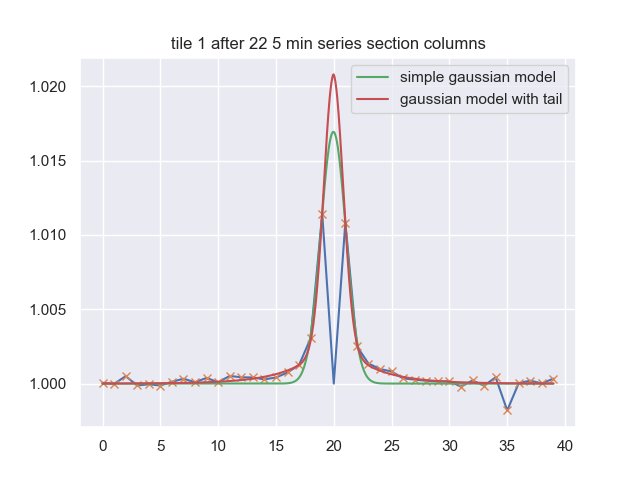

<IPython.core.display.Javascript object>


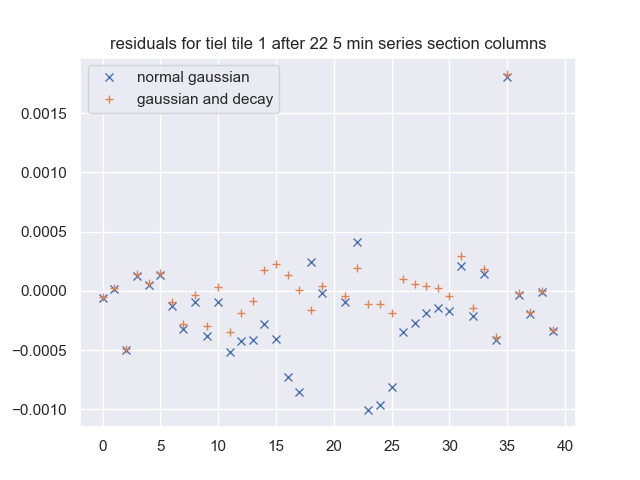

In [34]:
# only evaluate the good tiles for SNR
tilewise_popt_g = []
tilewise_popt_ge =[]
tilewise_SNR = []
# find the maximum and mask it and all surrouinding peaks to 0
for i in [1]: # good_tiles: 
    masked_arr = normalized_tilewise[i]
    # divide by bg value 
    masked_arr = masked_arr / np.nanmean(masked_arr.T[87:107, 485:505])
    # mask out 0 and 1 px correlation bins for the plot
    masked_arr[525, 127] = 1
    masked_arr[524, 127] = 1
    masked_arr[526, 127] = 1
    masked_arr[525, 126] = 1
    masked_arr[525, 128] = 1
    # nwo for the challenge: gaussian fit to this bad boy
    # since we do not want to fit to a masked array: 
    # fit in columns direction to cut data
    cut_data = masked_arr.T[107:147, 524]
    cut_data_x = np.arange(cut_data.size)
    # mask for the  fitting
    fit_mask = np.append(np.arange(0, 20), np.arange(21, 40))
    p0_g = [20, 2, 0.1]
    p0_ge = [20, 2, 0.1, 2, 0.1]
    popt_g, pcov_g = curve_fit(gaussian_1_px_units, cut_data_x[fit_mask], cut_data[fit_mask], p0=p0_g, bounds=(0, np.inf))
    popt_ge, pcov_ge = curve_fit(gaussian_with_tail, cut_data_x[fit_mask], cut_data[fit_mask], p0=p0_ge, bounds=(0, np.inf))

    # plt.figure()
    # plt.imshow(masked_arr.T[107:147, 505:545], vmin=0.98, vmax=1.02)
    # plt.colorbar()
    # plt.title('tile {} after {} 5 min series'.format(i, len(good_runs)) )
    # plt.show()
    # plot_x = np.linspace(0, np.amax(cut_data_x), num=1000)
    
    # plot fit model
    plt.figure()
    plt.plot(masked_arr.T[107:147, 524])
    plt.plot(cut_data_x[fit_mask], cut_data[fit_mask], linestyle='', marker='x')
    plt.plot(plot_x, gaussian_1_px_units(plot_x, *popt_g), label='simple gaussian model')
    plt.plot(plot_x, gaussian_with_tail(plot_x, *popt_ge), label='gaussian model with tail')
    plt.title('tile {} after {} 5 min series section columns'.format(i, len(good_runs)))
    plt.legend()
    plt.show()
    
    # plot residuals
    plt.figure()
    plt.plot(cut_data_x[fit_mask], gaussian_1_px_units(cut_data_x[fit_mask], *popt_g)-cut_data[fit_mask], label='normal gaussian', marker='x', linestyle='')
    plt.plot(cut_data_x[fit_mask], gaussian_with_tail(cut_data_x[fit_mask], *popt_ge)-cut_data[fit_mask], label='gaussian and decay', marker='+', linestyle='')
    plt.title('residuals for tiel tile {} after {} 5 min series section columns'.format(i, len(good_runs)))
    plt.legend()
    plt.show()
    
    #plt.show()
    #plt.figure()
    #plt.plot(masked_arr.T[127, 505:545])
    #plt.title('tile {} after {} 5 min series section rows'.format(i, len(good_runs)))
    #plt.show()
    #tilewise_popt_g.append(popt_g)
    #tilewise_popt_ge.append(popt_ge)

    virtual_peak_height = 1 # popt[-1]  # amplitude of gaussian
    # get std on line belonging to the measurement
    noise = np.std(masked_arr.T[:117, 524])
    SNR = virtual_peak_height / noise
    tilewise_SNR.append(SNR)

In [ ]:
expected_SNR = np.average(tilewise_SNR) * np.sqrt(len(tilewise_SNR))
expected_SNR_stdev = np.std(tilewise_SNR) * np.sqrt(len(tilewise_SNR))
print('SNR after {} series totaling {:.2e} images with {} photons: {} +- {}'.format(len(good_runs), 5*60*3000*len(good_runs), 3000, expected_SNR, expected_SNR_stdev))

In [ ]:
FWHM_diams = []
for params in tilewise_popt: 
    FWHM_diams.append(2.355*params[-2])
print('FWHM diameter: {} +- {}'.format(np.average(FWHM_diams), np.std(FWHM_diams)))

In [ ]:
tilewise_SNR